In [1]:
import cupy as cp
import numpy as np
import numba
from numba import njit, prange
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import cv2
from sklearn . model_selection import train_test_split
from sklearn . preprocessing import LabelEncoder , OneHotEncoder
from sklearn . metrics import confusion_matrix ,classification_report
import seaborn as sns
from sklearn.model_selection import KFold
from cupyx.scipy.signal import correlate2d, convolve2d


from sklearn.preprocessing import StandardScaler



/usr/local/lib/python3.11/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
def im2col(x, fH, fW, stride=1, pad=0):
    N, C, H, W = x.shape
    H_p, W_p = H + 2*pad, W + 2*pad
    x_p = cp.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)))
    out_h = (H_p - fH)//stride + 1
    out_w = (W_p - fW)//stride + 1
    i0 = cp.repeat(cp.arange(fH), fW)
    i0 = cp.tile(i0, C)
    i1 = stride * cp.repeat(cp.arange(out_h), out_w)
    j0 = cp.tile(cp.arange(fW), fH*C)
    j1 = stride * cp.tile(cp.arange(out_w), out_h)
    i = i0.reshape(-1,1) + i1.reshape(1,-1)
    j = j0.reshape(-1,1) + j1.reshape(1,-1)
    k = cp.repeat(cp.arange(C), fH*fW).reshape(-1,1)
    cols = x_p[:, k, i, j]  # (N, C*fH*fW, out_h*out_w)
    return cols.transpose(1,2,0).reshape(C*fH*fW, -1)

def col2im(cols, x_shape, fH, fW, stride=1, pad=0):
    N, C, H, W = x_shape
    H_p, W_p = H + 2*pad, W + 2*pad
    out_h = (H_p - fH)//stride + 1
    out_w = (W_p - fW)//stride + 1
    cols_reshaped = cols.reshape(C*fH*fW, out_h*out_w, N).transpose(2,0,1)
    x_p = cp.zeros((N, C, H_p, W_p))
    i0 = cp.repeat(cp.arange(fH), fW)
    i0 = cp.tile(i0, C)
    i1 = stride * cp.repeat(cp.arange(out_h), out_w)
    j0 = cp.tile(cp.arange(fW), fH*C)
    j1 = stride * cp.tile(cp.arange(out_w), out_h)
    i = i0.reshape(-1,1) + i1.reshape(1,-1)
    j = j0.reshape(-1,1) + j1.reshape(1,-1)
    k = cp.repeat(cp.arange(C), fH*fW).reshape(-1,1)
    for n in range(N):
        x_p[n, k, i, j] += cols_reshaped[n]
    if pad==0:
        return x_p
    return x_p[:, :, pad:-pad, pad:-pad]

In [19]:
class LeNet5:
    def __init__(self,
                 num_classes=33,
                 optimizer='adam',
                 lr=0.001,
                 regularisation=0.01,
                 beta1=0.9,
                 beta2=0.999,
                 eps=1e-8):
        """
        optimizer: 'sgd' or 'adam'
        regularisation: L2 regularization coefficient
        """
        self.optimizer = optimizer.lower()
        self.lr = lr
        self.regularisation = regularisation
        # Adam hyper-params
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.t = 0
        # Layers: init He
        self.W1 = cp.random.randn(6,1,5,5)*cp.sqrt(2/25); self.b1 = cp.zeros(6)
        self.W2 = cp.random.randn(16,6,5,5)*cp.sqrt(2/(6*25)); self.b2 = cp.zeros(16)
        self.W3 = cp.random.randn(400,120)*cp.sqrt(2/400); self.b3 = cp.zeros(120)
        self.W4 = cp.random.randn(120,84)*cp.sqrt(2/120);  self.b4 = cp.zeros(84)
        self.W5 = cp.random.randn(84,num_classes)*cp.sqrt(2/84); self.b5 = cp.zeros(num_classes)
        # Adam moments
        z1 = lambda p: cp.zeros_like(p)
        self.mW1, self.vW1 = z1(self.W1), z1(self.W1); self.mb1, self.vb1 = z1(self.b1), z1(self.b1)
        self.mW2, self.vW2 = z1(self.W2), z1(self.W2); self.mb2, self.vb2 = z1(self.b2), z1(self.b2)
        self.mW3, self.vW3 = z1(self.W3), z1(self.W3); self.mb3, self.vb3 = z1(self.b3), z1(self.b3)
        self.mW4, self.vW4 = z1(self.W4), z1(self.W4); self.mb4, self.vb4 = z1(self.b4), z1(self.b4)
        self.mW5, self.vW5 = z1(self.W5), z1(self.W5); self.mb5, self.vb5 = z1(self.b5), z1(self.b5)

    def _sgd_update(self, p, grad):
        # L2-regularized SGD
        p[:] -= self.lr * (grad + self.regularisation * p)

    def _adam_update(self, p, grad, m, v):
        # Adam with L2: add decay inside grad
        grad = grad + self.regularisation * p
        self.t += 1
        m[:] = self.beta1*m + (1-self.beta1)*grad
        v[:] = self.beta2*v + (1-self.beta2)*(grad*grad)
        m_hat = m/(1-self.beta1**self.t)
        v_hat = v/(1-self.beta2**self.t)
        p[:] -= self.lr * m_hat/(cp.sqrt(v_hat)+self.eps)

    def _update(self, p, grad, m=None, v=None):
        if self.optimizer=='adam':
            self._adam_update(p, grad, m, v)
        else:
            self._sgd_update(p, grad)

    def forward(self, X):
        N = X.shape[0]
        cols1 = im2col(X,5,5)
        o1 = self.W1.reshape(6,-1)@cols1 + self.b1.reshape(-1,1)
        o1 = o1.reshape(6,28,28,N).transpose(3,0,1,2)
        o1 = cp.maximum(o1,0)
        o1p = o1.reshape(N,6,14,2,14,2).mean(axis=(3,5))
        cols2 = im2col(o1p,5,5)
        o2 = self.W2.reshape(16,-1)@cols2 + self.b2.reshape(-1,1)
        o2 = o2.reshape(16,10,10,N).transpose(3,0,1,2)
        o2 = cp.maximum(o2,0)
        o2p= o2.reshape(N,16,5,2,5,2).mean(axis=(3,5))
        flat= o2p.reshape(N,-1)
        f3  = cp.maximum(flat@self.W3+self.b3,0)
        f4  = cp.maximum(f3  @self.W4+self.b4,0)
        logits = f4@self.W5+self.b5
        ex = cp.exp(logits-cp.max(logits,1,keepdims=True))
        probs = ex/ex.sum(1,keepdims=True)
        cache=(X,cols1,o1,o1p,cols2,o2,o2p,flat,f3,f4,probs)
        return probs,cache

    def backward(self, cache, y):
        X,cols1,o1,o1p,cols2,o2,o2p,flat,f3,f4,probs=cache
        N= X.shape[0]
        dlog=probs.copy(); dlog[cp.arange(N),y]-=1; dlog/=N
        dW5=f4.T@dlog; db5=dlog.sum(0)
        df4=(dlog@self.W5.T)*(f4>0)
        dW4=f3.T@df4; db4=df4.sum(0)
        df3=(df4@self.W4.T)*(f3>0)
        dW3=flat.T@df3; db3=df3.sum(0)
        dflat=df3@self.W3.T
        dS4=cp.kron(dflat.reshape(o2p.shape),cp.ones((1,1,2,2)))/4
        dout2=dS4*(o2>0)
        dout2_mat=dout2.transpose(1,2,3,0).reshape(16,-1)
        dW2=dout2_mat@cols2.T; db2=dout2_mat.sum(1)
        dcols2=(self.W2.reshape(16,-1).T@dout2_mat)
        dS2p=col2im(dcols2,(N,6,14,14),5,5)
        dS2=cp.kron(dS2p.reshape(o1p.shape),cp.ones((1,1,2,2)))/4
        dout1=dS2*(o1>0)
        dout1_mat=dout1.transpose(1,2,3,0).reshape(6,-1)
        dW1=dout1_mat@cols1.T; db1=dout1_mat.sum(1)
        # mise à jour
        self._update(self.W5,dW5,self.mW5,self.vW5); self._update(self.b5,db5,self.mb5,self.vb5)
        self._update(self.W4,dW4,self.mW4,self.vW4); self._update(self.b4,db4,self.mb4,self.vb4)
        self._update(self.W3,dW3,self.mW3,self.vW3); self._update(self.b3,db3,self.mb3,self.vb3)
        self._update(self.W2,dW2.reshape(self.W2.shape),self.mW2,self.vW2); self._update(self.b2,db2,self.mb2,self.vb2)
        self._update(self.W1,dW1.reshape(self.W1.shape),self.mW1,self.vW1); self._update(self.b1,db1,self.mb1,self.vb1)

    def compute_accuracy(self,y_true,y_pred):
        if y_pred.ndim==2: preds = np.argmax(y_pred,axis=1)
        else: preds = y_pred
        if y_true.ndim==2: true = np.argmax(y_true,axis=1)
        else: true = y_true
        assert preds.shape==true.shape
        return np.mean(preds==true)

    def train(self,X,y,Xv,yv,epochs=10,batch_size=64):
        Xg=cp.array(X).reshape(-1,1,32,32); yg=cp.array(y)
        Xvg=cp.array(Xv).reshape(-1,1,32,32); yvg=cp.array(yv)
        tr_ls,val_ls,tr_acc,val_acc=[],[],[],[]
        sub=min(batch_size,Xg.shape[0]); idx0=cp.arange(sub)
        for ep in range(epochs):
            perm=cp.random.permutation(Xg.shape[0])
            for i in range(0,Xg.shape[0],batch_size):
                idx=perm[i:i+batch_size]
                probs,cache=self.forward(Xg[idx]); self.backward(cache,yg[idx])
            pr, _ = self.forward(Xg[idx0])
            tr_ls.append(float(-cp.log(pr[cp.arange(sub),yg[idx0]]).mean()))
            tr_acc.append(self.compute_accuracy(cp.asnumpy(yg[idx0]), cp.asnumpy(cp.argmax(pr,axis=1))))
            pr_v,_=self.forward(Xvg)
            val_ls.append(float(-cp.log(pr_v[cp.arange(pr_v.shape[0]),yvg]).mean()))
            val_acc.append(self.compute_accuracy(cp.asnumpy(yvg), cp.asnumpy(cp.argmax(pr_v,axis=1))))
            print(f"Epoch {ep}, Train Loss: {tr_ls[-1] :.4f}, Val Loss: {val_ls[-1] :.4f}, "f"Train Acc: {tr_acc[-1] :.4f}, Val Acc:{val_acc[-1] :.4f}")


        return tr_ls,val_ls,tr_acc,val_acc
    def predict(self, X):
        # Conversion en halo GPU
        Xg = cp.array(X).reshape(-1,1,32,32)
        # Forward pass
        probs, _ = self.forward(Xg)
        # Argmax et conversion en NumPy
        preds = cp.argmax(probs, axis=1)
        return cp.asnumpy(preds)

In [29]:


# 1) dossier racine
data_dir = '/kaggle/input/tp6-tifinagh-grayscale/images-data-64/tifinagh-images'
csv_path = os.path.join(data_dir, '/kaggle/input/tp6-tifinagh-grayscale/images-data-64/labels-map.csv')

# 2) lire le CSV (rel_path + glyphe UTF-8)
df = pd.read_csv(
    csv_path,
    header=None,
    names=['rel_path', 'glyph'],
    dtype=str,
    encoding='utf-8'
)

# 3) NORMALISATION des chemins : ne garder que label/filename
def make_full_path(rel_p):
    p = Path(rel_p.lstrip('./'))           # supprime un "./" initial
    sub = p.parts[-2:]                     # ne garder que les 2 derniers segments
    return os.path.join(data_dir, *sub)

df['image_path'] = df['rel_path'].apply(make_full_path)

# 4) vérification d’existence
missing = df.loc[~df['image_path'].apply(os.path.exists), 'image_path']
if not missing.empty:
    raise FileNotFoundError("Fichiers introuvables :\n" + "\n".join(missing.tolist()))
print(f"✅ Chargé {len(df)} images, {df['glyph'].nunique()} classes.")

# 5) encoder les glyphes en entiers
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['glyph'])
num_classes = len(le.classes_)

# Fonction pour charger et p r t r a i t e r une image
def load_and_preprocess_image(image_path , target_size =(32, 32)):
    """
    Load and preprocess an image: convert to grayscale , resize ,
    normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
    assert img is not None , f"Failed to load image: {image_path}"
    img = cv2.resize(img , target_size)
    img = img.astype(np.float32) / 255.0 # Normalisation
    return img.flatten () # Aplatir pour le r s e a u de neurones
# 7) construire X et y

X = np.stack([load_and_preprocess_image(p) for p in df['image_path']])
y = df['label_enc'].values

# 8) split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")






✅ Chargé 28182 images, 33 classes.
Train=16908, Val=5637, Test=5637


Epoch 0, Train Loss: 3.4918, Val Loss: 3.5316, Train Acc: 0.0312, Val Acc:0.0488
Epoch 1, Train Loss: 3.3984, Val Loss: 3.4484, Train Acc: 0.0469, Val Acc:0.0761
Epoch 2, Train Loss: 3.3309, Val Loss: 3.3937, Train Acc: 0.0781, Val Acc:0.0992
Epoch 3, Train Loss: 3.2674, Val Loss: 3.3422, Train Acc: 0.0781, Val Acc:0.1148
Epoch 4, Train Loss: 3.2028, Val Loss: 3.2876, Train Acc: 0.1562, Val Acc:0.1334
Epoch 5, Train Loss: 3.1412, Val Loss: 3.2266, Train Acc: 0.1875, Val Acc:0.1485
Epoch 6, Train Loss: 3.0703, Val Loss: 3.1578, Train Acc: 0.1719, Val Acc:0.1685
Epoch 7, Train Loss: 2.9929, Val Loss: 3.0780, Train Acc: 0.2188, Val Acc:0.1909
Epoch 8, Train Loss: 2.9083, Val Loss: 2.9878, Train Acc: 0.2500, Val Acc:0.2127
Epoch 9, Train Loss: 2.8054, Val Loss: 2.8875, Train Acc: 0.2656, Val Acc:0.2352
Epoch 10, Train Loss: 2.7103, Val Loss: 2.7788, Train Acc: 0.2969, Val Acc:0.2586
Epoch 11, Train Loss: 2.5944, Val Loss: 2.6598, Train Acc: 0.3281, Val Acc:0.2856
Epoch 12, Train Loss: 2.49

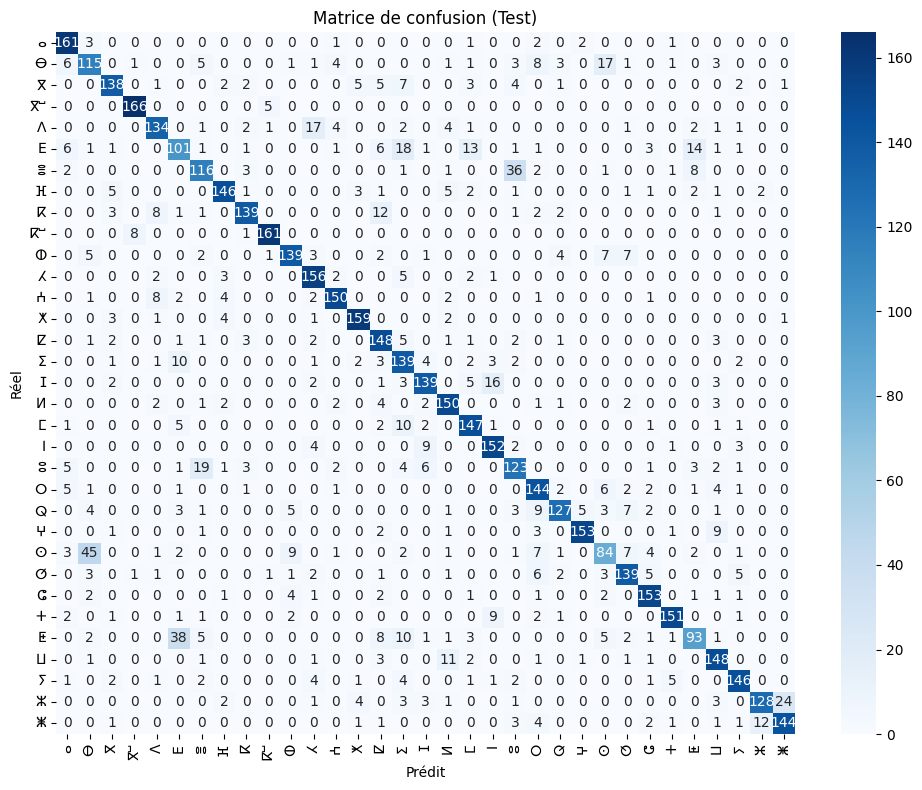

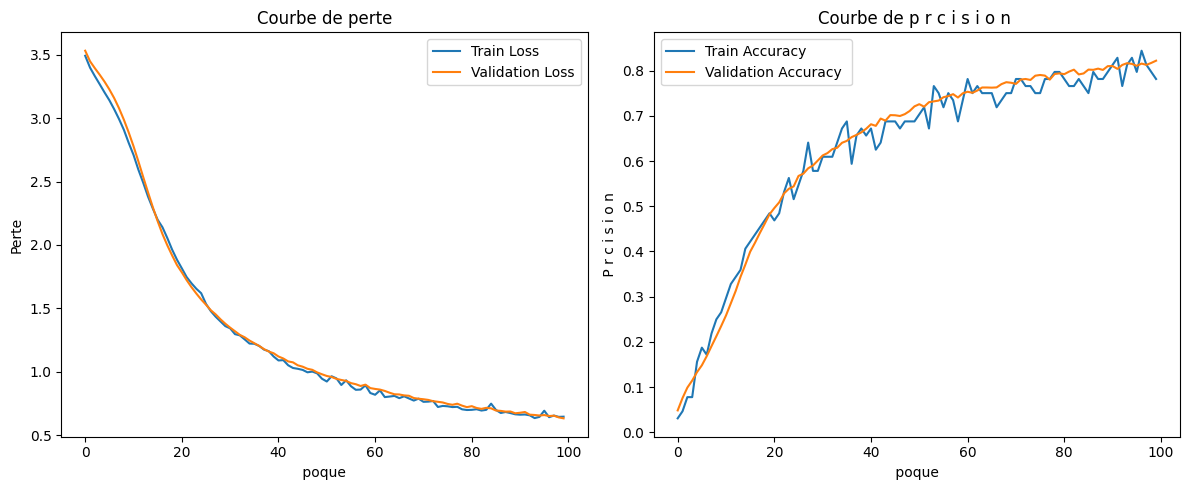

In [22]:
# 10) entraîner le modèle
# Avant entraînement

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train_reshaped = X_train.reshape(-1, 32, 32)
X_val_reshaped   = X_val.reshape(-1, 32, 32)
X_test_reshaped  = X_test.reshape(-1, 32, 32)

# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test


model = LeNet5(num_classes=33,optimizer='sgd',lr=0.001,regularisation=0.01
)

# Entraînement avec labels (pas one-hot)
train_losses, val_losses,train_acc,val_acc = model.train(
    X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100
)


# 11) évaluer sur test
y_pred = model.predict(X_test)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()




In [27]:
# 10) entraîner le modèle
# Avant entraînement

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train_reshaped = X_train.reshape(-1, 32, 32)
X_val_reshaped   = X_val.reshape(-1, 32, 32)
X_test_reshaped  = X_test.reshape(-1, 32, 32)

# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test


model = LeNet5(num_classes=33,optimizer='adam',lr=0.001,regularisation=0.01
)

# Entraînement avec labels (pas one-hot)
train_losses, val_losses,train_acc,val_acc = model.train(
    X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100
)


# 11) évaluer sur test
y_pred = model.predict(X_test)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()


Epoch 0, Train Loss: 0.9925, Val Loss: inf, Train Acc: 0.6094, Val Acc:0.4180
Epoch 1, Train Loss: 0.7374, Val Loss: inf, Train Acc: 0.7344, Val Acc:0.3591
Epoch 2, Train Loss: 0.6694, Val Loss: inf, Train Acc: 0.8125, Val Acc:0.3811
Epoch 3, Train Loss: 0.5978, Val Loss: inf, Train Acc: 0.8281, Val Acc:0.3481
Epoch 4, Train Loss: 0.5657, Val Loss: inf, Train Acc: 0.8125, Val Acc:0.3491
Epoch 5, Train Loss: 0.5419, Val Loss: inf, Train Acc: 0.8438, Val Acc:0.2879
Epoch 6, Train Loss: 0.4545, Val Loss: inf, Train Acc: 0.8594, Val Acc:0.3883
Epoch 7, Train Loss: 0.4365, Val Loss: inf, Train Acc: 0.8750, Val Acc:0.3592
Epoch 8, Train Loss: 0.3611, Val Loss: inf, Train Acc: 0.9219, Val Acc:0.3674
Epoch 9, Train Loss: 0.4342, Val Loss: inf, Train Acc: 0.8594, Val Acc:0.3468
Epoch 10, Train Loss: 0.3977, Val Loss: inf, Train Acc: 0.9062, Val Acc:0.3936
Epoch 11, Train Loss: 0.4145, Val Loss: inf, Train Acc: 0.8750, Val Acc:0.3621
Epoch 12, Train Loss: 0.3998, Val Loss: inf, Train Acc: 0.9219

KeyboardInterrupt: 

Testing λ=0.01, lr=0.001, batch_size=128 ...
Epoch 0, Train Loss: 3.5711, Val Loss: 3.5666, Train Acc: 0.0312, Val Acc:0.0370
Epoch 1, Train Loss: 3.4833, Val Loss: 3.4812, Train Acc: 0.0547, Val Acc:0.0612
Epoch 2, Train Loss: 3.4338, Val Loss: 3.4263, Train Acc: 0.0781, Val Acc:0.0714
Epoch 3, Train Loss: 3.3924, Val Loss: 3.3793, Train Acc: 0.0859, Val Acc:0.0887
Epoch 4, Train Loss: 3.3525, Val Loss: 3.3337, Train Acc: 0.0938, Val Acc:0.1036
Epoch 5, Train Loss: 3.3092, Val Loss: 3.2861, Train Acc: 0.1172, Val Acc:0.1213
Epoch 6, Train Loss: 3.2601, Val Loss: 3.2346, Train Acc: 0.1719, Val Acc:0.1415
Epoch 7, Train Loss: 3.2030, Val Loss: 3.1782, Train Acc: 0.2031, Val Acc:0.1674
Epoch 8, Train Loss: 3.1407, Val Loss: 3.1166, Train Acc: 0.2109, Val Acc:0.1894
Epoch 9, Train Loss: 3.0717, Val Loss: 3.0498, Train Acc: 0.2188, Val Acc:0.2129
Epoch 10, Train Loss: 2.9948, Val Loss: 2.9779, Train Acc: 0.2422, Val Acc:0.2309
Epoch 11, Train Loss: 2.9123, Val Loss: 2.8996, Train Acc: 0.25

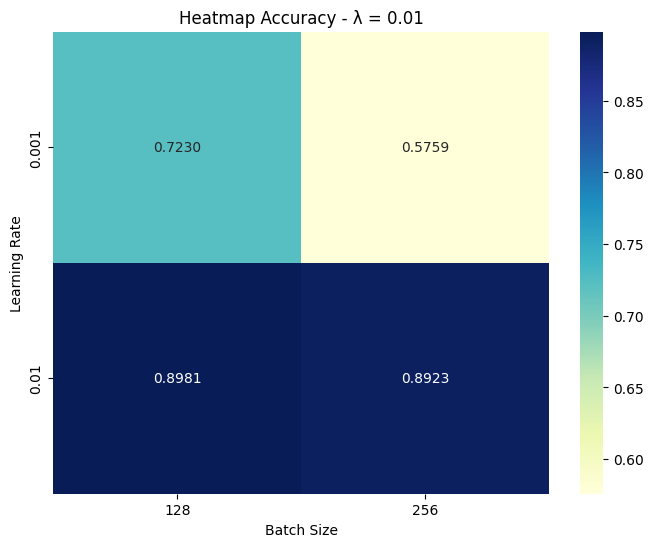

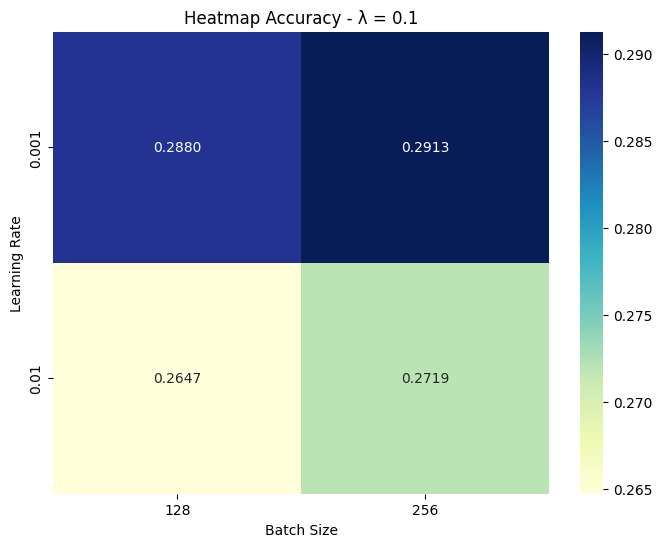

Epoch 0, Train Loss: 3.1337, Val Loss: 3.1095, Train Acc: 0.1406, Val Acc:0.1765
Epoch 1, Train Loss: 2.5226, Val Loss: 2.4783, Train Acc: 0.2422, Val Acc:0.2803
Epoch 2, Train Loss: 2.0574, Val Loss: 2.0148, Train Acc: 0.3594, Val Acc:0.3869
Epoch 3, Train Loss: 1.7336, Val Loss: 1.7031, Train Acc: 0.4531, Val Acc:0.4698
Epoch 4, Train Loss: 1.9239, Val Loss: 1.9757, Train Acc: 0.3516, Val Acc:0.3862
Epoch 5, Train Loss: 1.5676, Val Loss: 1.5196, Train Acc: 0.4844, Val Acc:0.5056
Epoch 6, Train Loss: 1.3740, Val Loss: 1.3580, Train Acc: 0.5000, Val Acc:0.5753
Epoch 7, Train Loss: 1.2157, Val Loss: 1.2262, Train Acc: 0.6016, Val Acc:0.6017
Epoch 8, Train Loss: 1.5981, Val Loss: 1.4712, Train Acc: 0.4922, Val Acc:0.5279
Epoch 9, Train Loss: 1.3833, Val Loss: 1.3079, Train Acc: 0.5938, Val Acc:0.5936
Epoch 10, Train Loss: 1.2337, Val Loss: 1.1784, Train Acc: 0.5859, Val Acc:0.6252
Epoch 11, Train Loss: 1.3198, Val Loss: 1.2155, Train Acc: 0.5625, Val Acc:0.6079
Epoch 12, Train Loss: 1.12

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


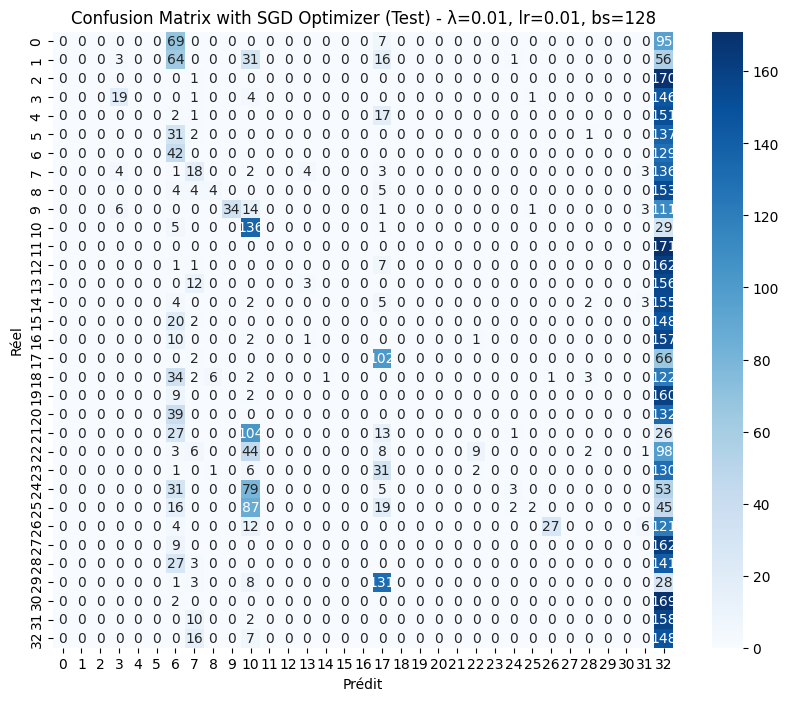

In [25]:
# ----- Définir les hyperparamètres à tester pour model avec optimizer SGD-----
learning_rates = [0.001, 0.01]
batch_sizes    = [128, 256]
lamda_value    = [0.01, 0.1]
n_splits       = 5

# Préparer un tableau 3D : (lr, bs, lamda)
mean_val_accuracy = np.zeros((len(learning_rates), len(batch_sizes), len(lamda_value)))


# ----- Standardisation -----
scaler = StandardScaler()
X_temp = scaler.fit_transform(X_temp)
X_val  = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# ----- Recherche par Cross-Validation -----
for k, lm in enumerate(lamda_value):
    for i, lr in enumerate(learning_rates):
        for j, bs in enumerate(batch_sizes):
            
            print(f"Testing λ={lm}, lr={lr}, batch_size={bs} ...")
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            fold_accuracies = []
    
            for train_index, val_index in kf.split(X_temp):
                
                X_train_fold = X_temp[train_index]
                X_val_fold   = X_temp[val_index]
                y_train_fold = y_temp[train_index]
                y_val_fold   = y_temp[val_index]
                
                # Initialiser le modèle
                model = LeNet5(num_classes=33,optimizer='sgd',lr=lr,regularisation=lm)
    
                # Entraînement
                _, val_losses, _, val_accs = model.train(
                    X_train_fold, y_train_fold,
                    X_val_fold,   y_val_fold,
                    epochs=100, batch_size=bs
                )
                
                fold_accuracies.append(val_accs[-1])
            
            mean_val_accuracy[i, j, k] = np.mean(fold_accuracies)
            print(f"→ Moyenne CV accuracy λ={lm}, lr={lr}, bs={bs} : {mean_val_accuracy[i, j, k]:.4f}")

# ----- Identifier la meilleure combinaison -----
best_idx = np.unravel_index(np.argmax(mean_val_accuracy), mean_val_accuracy.shape)
best_lr  = learning_rates[best_idx[0]]
best_bs  = batch_sizes[best_idx[1]]
best_lm  = lamda_value[best_idx[2]]
best_acc = mean_val_accuracy[best_idx]

print(f"\nMeilleure combinaison SGD : λ={best_lm}, lr={best_lr}, bs={best_bs} avec CV accuracy={best_acc:.4f}")

# ----- Heatmaps séparées pour chaque λ -----
for k, lm in enumerate(lamda_value):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        mean_val_accuracy[:, :, k],
        annot=True, fmt=".4f",
        xticklabels=batch_sizes,
        yticklabels=learning_rates,
        cmap="YlGnBu"
    )
    plt.title(f"Heatmap Accuracy - λ = {lm}")
    plt.xlabel("Batch Size")
    plt.ylabel("Learning Rate")
    plt.savefig(f"cv_accuracy_heatmap_lambda_{lm}.png")
    plt.show()

# ----- Réentraînement final avec les meilleurs hyperparamètres -----
model = LeNet5(num_classes=33,optimizer='sgd',lr=best_lr,regularisation=best_lm)


model.train(X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100,batch_size=best_bs
)

# ----- Évaluation finale -----
y_test_pred = model.predict(X_test)

print("\nRapport de classification (Test set) avec la meilleure combinaison :")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix with SGD Optimizer (Test) - λ={best_lm}, lr={best_lr}, bs={best_bs}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("confusion_matrix_best.png")
plt.show()

Epoch 0, Train Loss: 3.2123, Val Loss: 3.1278, Train Acc: 0.1094, Val Acc:0.1547
Epoch 1, Train Loss: 2.4749, Val Loss: 2.4614, Train Acc: 0.3359, Val Acc:0.3262
Epoch 2, Train Loss: 2.3330, Val Loss: 2.2278, Train Acc: 0.3281, Val Acc:0.3239
Epoch 3, Train Loss: 1.9369, Val Loss: 1.8090, Train Acc: 0.4141, Val Acc:0.4454
Epoch 4, Train Loss: 1.5483, Val Loss: 1.5135, Train Acc: 0.5234, Val Acc:0.5230
Epoch 5, Train Loss: 1.3376, Val Loss: 1.2973, Train Acc: 0.5781, Val Acc:0.5968
Epoch 6, Train Loss: 1.3260, Val Loss: 1.2341, Train Acc: 0.5625, Val Acc:0.6145
Epoch 7, Train Loss: 1.4728, Val Loss: 1.4060, Train Acc: 0.4844, Val Acc:0.5680
Epoch 8, Train Loss: 1.9665, Val Loss: 1.8610, Train Acc: 0.4922, Val Acc:0.4941
Epoch 9, Train Loss: 1.0034, Val Loss: 1.0284, Train Acc: 0.6562, Val Acc:0.6603
Epoch 10, Train Loss: 0.9703, Val Loss: 1.0046, Train Acc: 0.6875, Val Acc:0.6727
Epoch 11, Train Loss: 0.9242, Val Loss: 0.9644, Train Acc: 0.6875, Val Acc:0.6862
Epoch 12, Train Loss: 1.00

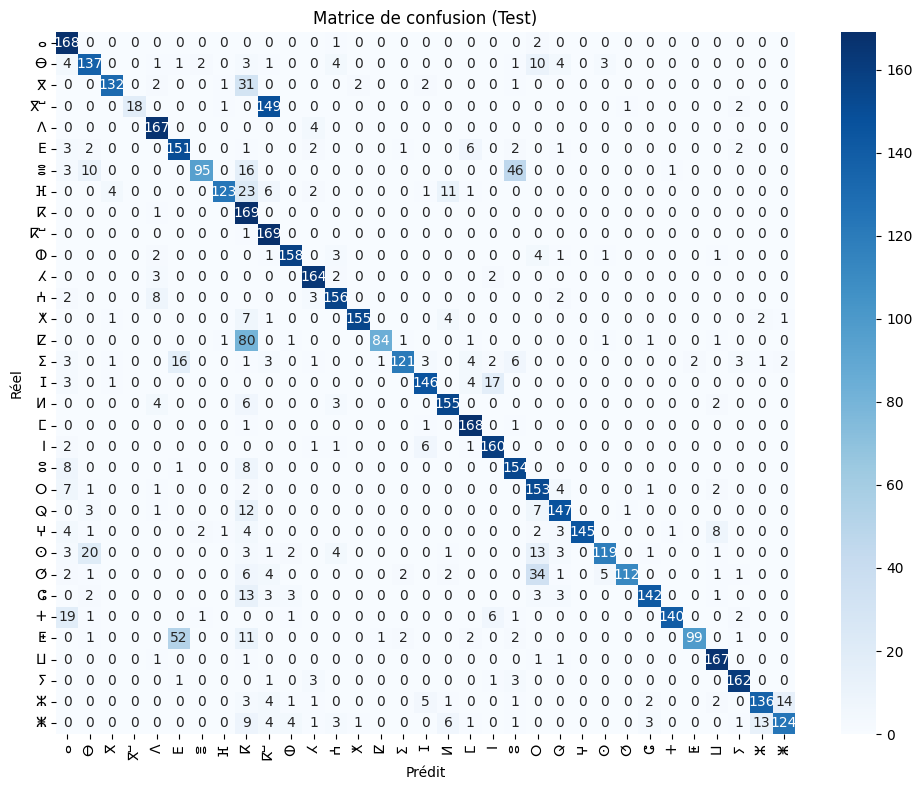

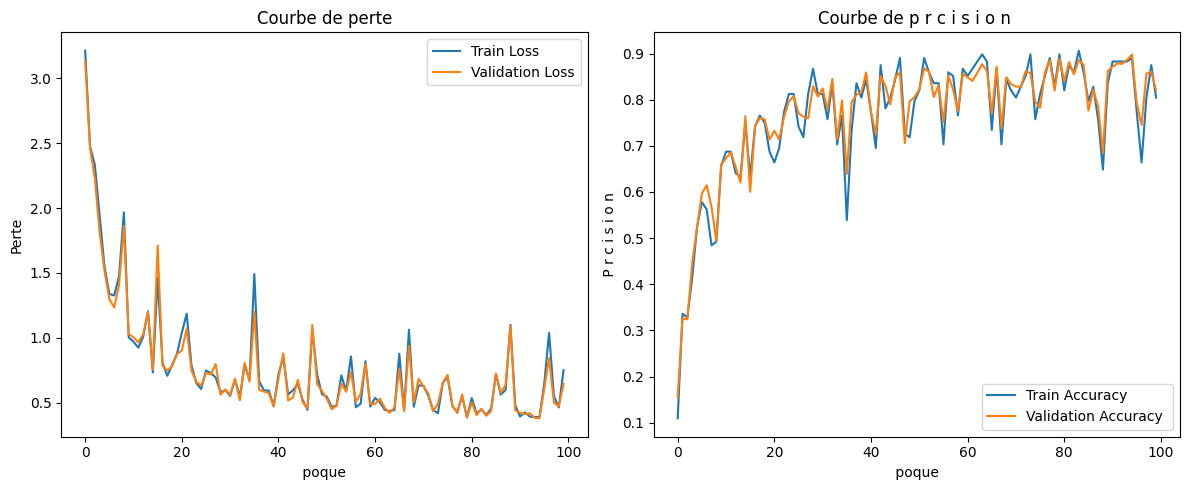

In [30]:
# 10) entraîner le modèle
# Avant entraînement

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train_reshaped = X_train.reshape(-1, 32, 32)
X_val_reshaped   = X_val.reshape(-1, 32, 32)
X_test_reshaped  = X_test.reshape(-1, 32, 32)

# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test



model = LeNet5(num_classes=33,optimizer='sgd',lr=best_lr,regularisation=best_lm)


# Entraînement avec labels (pas one-hot)
train_losses, val_losses,train_acc,val_acc = model.train(
    X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100,batch_size=best_bs
)


# 11) évaluer sur test
y_pred = model.predict(X_test)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()




In [ ]:
# ----- Définir les hyperparamètres à tester pour model avec optimizer Adam-----
learning_rates = [0.001, 0.01]
batch_sizes    = [128, 256]
lamda_value    = [0.01, 0.1]
n_splits       = 5

# Préparer un tableau 3D : (lr, bs, lamda)
mean_val_accuracy = np.zeros((len(learning_rates), len(batch_sizes), len(lamda_value)))


# ----- Standardisation -----
scaler = StandardScaler()
X_temp = scaler.fit_transform(X_temp)
X_val  = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# ----- Recherche par Cross-Validation -----
for k, lm in enumerate(lamda_value):
    for i, lr in enumerate(learning_rates):
        for j, bs in enumerate(batch_sizes):
            
            print(f"Testing λ={lm}, lr={lr}, batch_size={bs} ...")
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            fold_accuracies = []
    
            for train_index, val_index in kf.split(X_temp):
                
                X_train_fold = X_temp[train_index]
                X_val_fold   = X_temp[val_index]
                y_train_fold = y_temp[train_index]
                y_val_fold   = y_temp[val_index]
                
                # Initialiser le modèle
                model = LeNet5(num_classes=33,optimizer='adam',lr=lr,regularisation=lm)
    
                # Entraînement
                _, val_losses, _, val_accs = model.train(
                    X_train_fold, y_train_fold,
                    X_val_fold,   y_val_fold,
                    epochs=100, batch_size=bs
                )
                
                fold_accuracies.append(val_accs[-1])
            
            mean_val_accuracy[i, j, k] = np.mean(fold_accuracies)
            print(f"→ Moyenne CV accuracy λ={lm}, lr={lr}, bs={bs} : {mean_val_accuracy[i, j, k]:.4f}")

# ----- Identifier la meilleure combinaison -----
best_idx = np.unravel_index(np.argmax(mean_val_accuracy), mean_val_accuracy.shape)
best_lr  = learning_rates[best_idx[0]]
best_bs  = batch_sizes[best_idx[1]]
best_lm  = lamda_value[best_idx[2]]
best_acc = mean_val_accuracy[best_idx]

print(f"\nMeilleure combinaison SGD : λ={best_lm}, lr={best_lr}, bs={best_bs} avec CV accuracy={best_acc:.4f}")

# ----- Heatmaps séparées pour chaque λ -----
for k, lm in enumerate(lamda_value):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        mean_val_accuracy[:, :, k],
        annot=True, fmt=".4f",
        xticklabels=batch_sizes,
        yticklabels=learning_rates,
        cmap="YlGnBu"
    )
    plt.title(f"Heatmap Accuracy - λ = {lm}")
    plt.xlabel("Batch Size")
    plt.ylabel("Learning Rate")
    plt.savefig(f"cv_accuracy_heatmap_lambda_{lm}.png")
    plt.show()

# ----- Réentraînement final avec les meilleurs hyperparamètres -----
model = LeNet5(num_classes=33,optimizer='adam',lr=best_lr,regularisation=best_lm)


model.train(X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100,batch_size=best_bs
)

# ----- Évaluation finale -----
y_test_pred = model.predict(X_test)

print("\nRapport de classification (Test set) avec la meilleure combinaison :")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix with Adam Optimizer (Test) - λ={best_lm}, lr={best_lr}, bs={best_bs}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("confusion_matrix_best.png")
plt.show()

In [8]:

# D f i n i r le chemin vers le dossier d c o m p r e s s
data_dir = os.path.join(os.getcwd (), '/kaggle/input/tp6-tifinagh-grayscale/images-data-64/images_augmentees')
print(data_dir)
current_working_directory = os.getcwd ()
print(current_working_directory)

# Charger le fichier CSV contenant les tiquettes
try:
    # labels_df = pd.read_csv(os.path.join(data_dir , '/kaggle/input/amhcdd/images-data-64/labels-map.csv'))
    labels_df = pd.read_csv(os.path.join(data_dir , '/kaggle/input/tp6-tifinagh-grayscale/images-data-64/labels-map.csv'), header=None, names=['image_path', 'label'])

    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns , "CSV must contain ’image_path’ and ’label’ columns"
except FileNotFoundError:
    print("labels -map.csv not found. Please check the dataset structure.")
# Alternative : construire un DataFrame partir des dossiers
image_paths = []
labels = []
for label_dir in os.listdir(data_dir):
    label_path = os.path.join(data_dir , label_dir)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            image_paths.append(os.path.join(label_path ,
            img_name))
            labels.append(label_dir)
labels_df = pd.DataFrame ({'image_path': image_paths , 'label': labels })

# V r i f i e r le DataFrame
assert not labels_df.empty , "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique ()} unique classes.")

# Encoder les tiquettes
label_encoder = LabelEncoder ()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et p r t r a i t e r une image
def load_and_preprocess_image(image_path , target_size =(32, 32)):
    """
    Load and preprocess an image: convert to grayscale , resize ,
    normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
    assert img is not None , f"Failed to load image: {image_path}"
    img = cv2.resize(img , target_size)
    img = img.astype(np.float32) / 255.0 # Normalisation
    return img.flatten () # Aplatir pour le r s e a u de neurones

# Charger toutes les images
X = np.array([ load_and_preprocess_image(os.path.join(data_dir ,path)) for path in labels_df['image_path']])
y = labels_df['label_encoded']. values

# V r i f i e r les dimensions
assert X.shape [0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape [1] == 32 * 32, f"Expected flattened image size of {32*32} , got {X.shape [1]}"

# Diviser en ensembles d’ entra nement , validation et test
X_temp , X_test , y_temp , y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state =42)
X_train , X_val , y_train , y_val = train_test_split(X_temp , y_temp , test_size =0.25, stratify=y_temp , random_state =42)

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")



/kaggle/input/tp6-tifinagh-grayscale/images-data-64/images_augmentees
/kaggle/working
Loaded 112728 samples with 33 unique classes.
Train=67636, Val=22546, Test=22546


Epoch 0 - Loss(TR/VAL): 0.5333/0.6436 Acc(TR/VAL): 0.8438/0.7846
Epoch 1 - Loss(TR/VAL): 0.3710/0.4169 Acc(TR/VAL): 0.8438/0.8574
Epoch 2 - Loss(TR/VAL): 0.4222/0.3489 Acc(TR/VAL): 0.8594/0.8786
Epoch 3 - Loss(TR/VAL): 0.2789/0.2912 Acc(TR/VAL): 0.9062/0.9003
Epoch 4 - Loss(TR/VAL): 0.1202/0.2587 Acc(TR/VAL): 0.9531/0.9087
Epoch 5 - Loss(TR/VAL): 0.3036/0.2575 Acc(TR/VAL): 0.8438/0.9123
Epoch 6 - Loss(TR/VAL): 0.1987/0.2361 Acc(TR/VAL): 0.9219/0.9199
Epoch 7 - Loss(TR/VAL): 0.1819/0.2211 Acc(TR/VAL): 0.9531/0.9269
Epoch 8 - Loss(TR/VAL): 0.1347/0.2121 Acc(TR/VAL): 0.9688/0.9289
Epoch 9 - Loss(TR/VAL): 0.0569/0.2121 Acc(TR/VAL): 0.9688/0.9316
Epoch 10 - Loss(TR/VAL): 0.1031/0.2215 Acc(TR/VAL): 0.9375/0.9314
Epoch 11 - Loss(TR/VAL): 0.1361/0.2168 Acc(TR/VAL): 0.9219/0.9348
Epoch 12 - Loss(TR/VAL): 0.1172/0.2095 Acc(TR/VAL): 0.9688/0.9338
Epoch 13 - Loss(TR/VAL): 0.1082/0.2077 Acc(TR/VAL): 0.9688/0.9368
Epoch 14 - Loss(TR/VAL): 0.0974/0.2212 Acc(TR/VAL): 0.9531/0.9358
Epoch 15 - Loss(TR/V

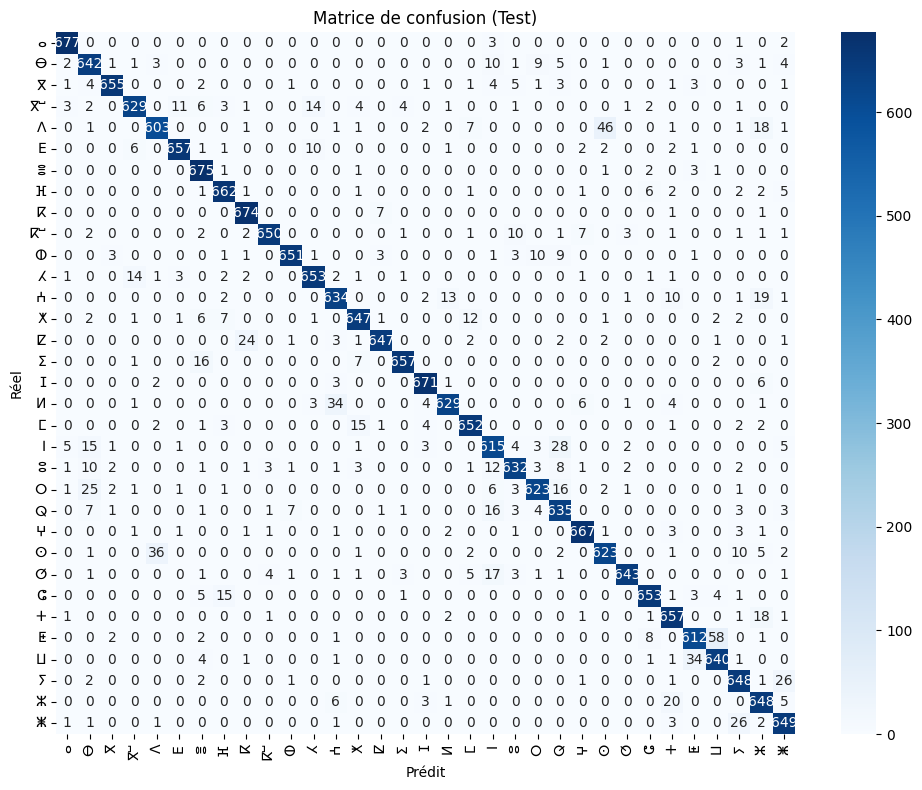

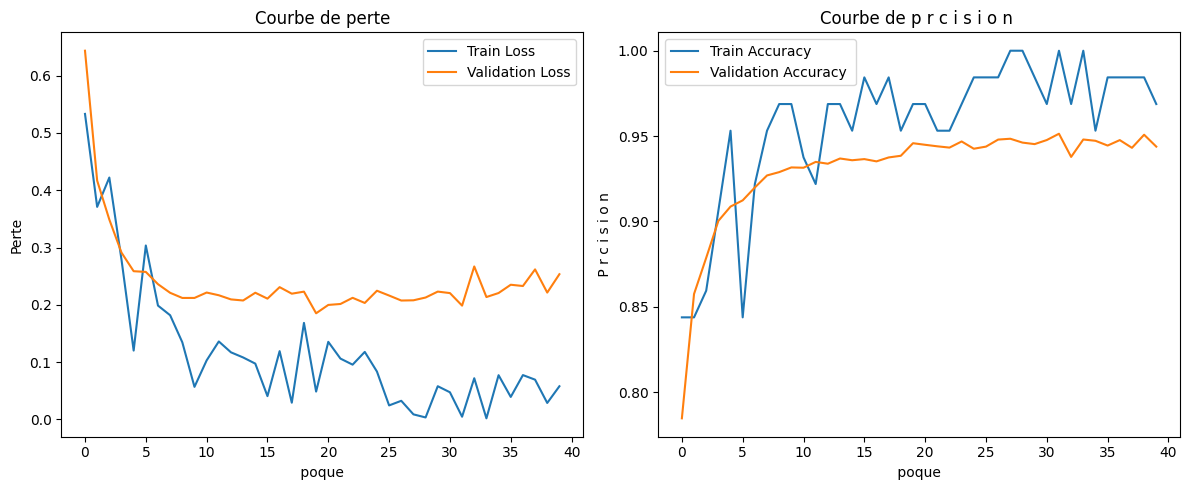

In [9]:
# 10) entraîner le modèle
# Avant entraînement

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train_reshaped = X_train.reshape(-1, 32, 32)
X_val_reshaped   = X_val.reshape(-1, 32, 32)
X_test_reshaped  = X_test.reshape(-1, 32, 32)

# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test


model = LeNet5(num_classes=33)

# Entraînement avec labels (pas one-hot)
train_losses, val_losses,train_acc,val_acc = model.train(
    X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=40
)


# 11) évaluer sur test
y_pred = model.predict(X_test)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()


